In [1]:
!pip install -q -U datasets bitsandbytes
# !pip install -q -U git+https://github.com/huggingface/peft.git
# !pip install -q -U git+https://github.com/huggingface/transformers.git

In [2]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer, BitsAndBytesConfig
import torch

In [3]:
config = {
    'base_model': 'albert/albert-base-v2',
    'dataset': 'SetFit/mrpc',
}

In [4]:
tokenizer = AutoTokenizer.from_pretrained(config['base_model'])

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

# Data Loading

In [ ]:
ds = load_dataset(config['dataset'])
ds

Repo card metadata block was not found. Setting CardData to empty.


Generating train split:   0%|          | 0/3668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/408 [00:00<?, ? examples/s]

In [ ]:
print(f"Sentence 1: {ds['train']['text1'][0]}\nSentence 2: {ds['train']['text2'][0]}\nTwo sentences are {ds['train']['label_text'][0]}")

Sentence 1: Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .
Sentence 2: Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .
Two sentences are equivalent


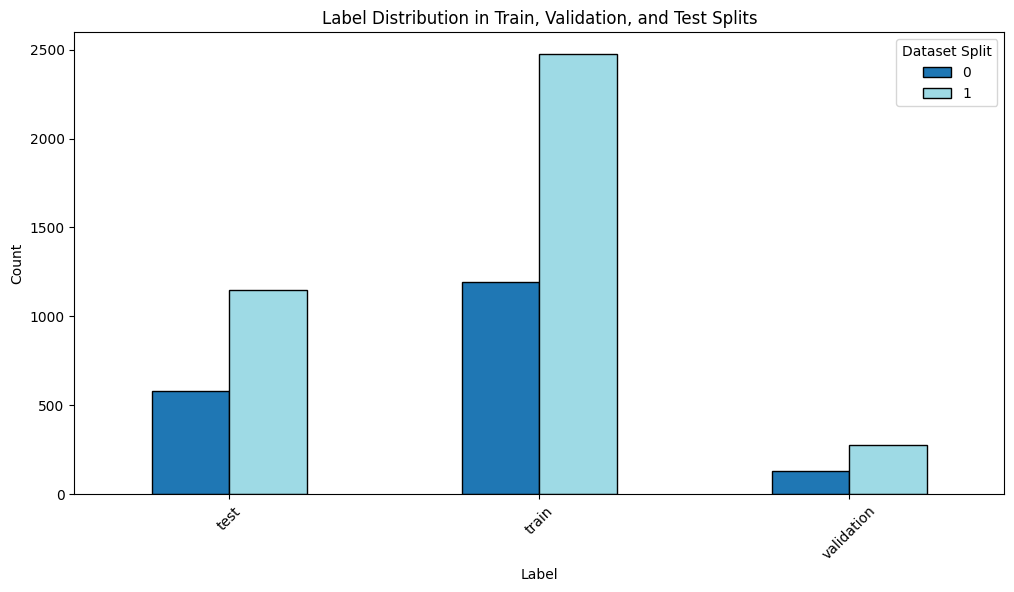

In [7]:
train_labels = ds['train']['label']
validation_labels = ds['validation']['label']
test_labels = ds['test']['label']

train_df = pd.DataFrame(train_labels, columns=['label'])
validation_df = pd.DataFrame(validation_labels, columns=['label'])
test_df = pd.DataFrame(test_labels, columns=['label'])

train_df['split'] = 'train'
validation_df['split'] = 'validation'
test_df['split'] = 'test'

combined_df = pd.concat([train_df, validation_df, test_df])

label_counts = combined_df.groupby(['split', 'label']).size().unstack().fillna(0)

label_counts.plot(kind='bar', figsize=(12, 6), colormap='tab20', edgecolor='black')
plt.title('Label Distribution in Train, Validation, and Test Splits')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Dataset Split')
plt.show()

In [8]:
tokenizer.encode_plus('This is sentence 1', 'This is sentence 2')

{'input_ids': [2, 48, 25, 5123, 137, 3, 48, 25, 5123, 172, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [9]:
class MRPC:
    def __init__(self, data, tokenizer, max_length=256):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        # Pre-process data
        self.encoded_data = []
        for item in self.data:
            inputs = self.tokenizer.encode_plus(
                item['text1'], item['text2'],
                add_special_tokens=True,
                max_length=self.max_length,
                truncation=True,
                padding='max_length',
                return_tensors='pt'
            )
            self.encoded_data.append({
                'input_ids': inputs['input_ids'].squeeze(),
                'attention_mask': inputs['attention_mask'].squeeze(),
                'token_type_ids': inputs['token_type_ids'].squeeze(),
                'labels': torch.tensor(item["label"], dtype=torch.long)
            })
    
    def __len__(self):
        return len(self.encoded_data)
    
    def __getitem__(self, idx):
        return self.encoded_data[idx]

train_ds = MRPC(ds['train'], tokenizer)
val_ds = MRPC(ds['validation'], tokenizer)

In [10]:
test_input = train_ds.__getitem__(2)
test_input

{'input_ids': tensor([    2,    59,    41,   467,    40, 17128,    27,    14,  2620,    27,
           295,   332,    13,    15,  4090,    14,  5570,    26,  3299,    13,
            15,    24,   905,    13,     9,     3,    27,   295,   332,    13,
            15,    14,   995,    13,    22,    18,  4515,    41,   467,    40,
         17128,    27,    14,  2620,    13,    15,  4090,    14, 17256,    26,
          3299,    13,     9,     3,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [11]:
import torch.nn as nn

class STSModel(nn.Module):
    def __init__(self, base_model, lstm_hidden_dim=64, num_classes=2):
        super(STSModel, self).__init__()
        self.base_model = AutoModel.from_pretrained(base_model)

        
        self.bi_lstm = nn.LSTM(
            input_size=self.base_model.config.hidden_size,  # Size of BERT output features
            hidden_size=lstm_hidden_dim,
            num_layers=1,
            bidirectional=True,
            batch_first=True,
            dropout=0.3
        )
        
        # bidirectional *2, avg+maxpooling *2
        self.fc = nn.Linear(lstm_hidden_dim *2 *2, num_classes)
        
        self.dropout = nn.Dropout(0.3)
            
    def forward(self, input_ids, attention_mask, token_type_ids, labels=None):
        outputs = self.base_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        # Model's output
        sequence_output = outputs.last_hidden_state
        pooled_output = outputs.pooler_output
        
        # LSTM
        lstm_out, _ = self.bi_lstm(sequence_output)
        
        # Pooling
        avg_pool = torch.mean(lstm_out, dim=1)
        max_pool, _ = torch.max(lstm_out, dim=1)
        
        # Concat pooling layers
        concat = torch.cat((avg_pool, max_pool), dim=1)
        
        # Dropout
        dropout = self.dropout(concat)
        
        # Fully connected
        logits = self.fc(dropout)
        
        if labels is not None:
            labels = labels
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
            return loss, logits
        
        return logits
    
model = STSModel(config['base_model'])

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [12]:
# Đảm bảo rằng labels có kích thước phù hợp với batch size
test_labels = test_input['labels'].unsqueeze(0)  # Thêm một chiều cho labels nếu cần thiết

# Truyền các tensor vào mô hình
test_output = model(
    test_input['input_ids'].unsqueeze(0), 
    test_input['attention_mask'].unsqueeze(0), 
    test_input['token_type_ids'].unsqueeze(0), 
    test_labels
)

# In hoặc kiểm tra kết quả
print(test_output)


(tensor(0.6932, grad_fn=<NllLossBackward0>), tensor([[0.2268, 0.2267]], grad_fn=<AddmmBackward0>))


In [13]:
from datasets import load_metric
import numpy as np

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

/tmp/ipykernel_34/617475896.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


The repository for accuracy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/accuracy.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


In [14]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',            # Directory to save model checkpoints and other outputs
    eval_strategy="epoch",       # When to run evaluation (options: "no", "epoch", "steps")
    learning_rate=2e-5,                 # Learning rate
    per_device_train_batch_size=8,      # Batch size per device during training
    per_device_eval_batch_size=8,       # Batch size per device during evaluation
    num_train_epochs=10,                 # Total number of training epochs
    weight_decay=0.01,                  # Weight decay to apply (if any)
    logging_dir='./logs',               # Directory for storing logs
    logging_steps=10,                   # Number of steps between logging
    save_steps=10_000,                  # Number of steps between saving checkpoints
    report_to="none"
)

In [15]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
)

2024-08-11 08:15:30.670068: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-11 08:15:30.670189: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-11 08:15:30.832162: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [16]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.436200,0.362883,0.855392
2,0.301200,0.421995,0.818627
3,0.154300,0.412518,0.862745
4,0.185200,0.539774,0.867647
5,0.126200,0.614489,0.857843
6,0.003700,0.690486,0.857843
7,0.002100,0.707560,0.872549
8,0.001700,0.671530,0.867647
9,0.001600,0.697545,0.875000
10,0.001800,0.709496,0.877451


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=2300, training_loss=0.14814995973249492, metrics={'train_runtime': 916.4531, 'train_samples_per_second': 40.024, 'train_steps_per_second': 2.51, 'total_flos': 0.0, 'train_loss': 0.14814995973249492, 'epoch': 10.0})

In [17]:
trainer.evaluate()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.7094964385032654,
 'eval_accuracy': 0.8774509803921569,
 'eval_runtime': 3.6328,
 'eval_samples_per_second': 112.311,
 'eval_steps_per_second': 7.157,
 'epoch': 10.0}